### General Assembly Part-Time Data Science Final Project

### Proposal:
I've decided to investigate the suggested craft beer dataset. My goal is to attempt to predict quality ratings and popularity from the available data. The initial dataset is from Kaggle, which includes a list of beers and a list of breweries, but not ratings. (https://www.kaggle.com/nickhould/craft-cans)

I submitted a request to RateBeer.com for API access, which did not receive a response. As an alternative source for ratings data, I decided to scrape a popular wesbite, Beer Advocate (https://www.beeradvocate.com). This would give me their Beer Advocate score, as well as user ratings and how many users had rated the beer. I also liked this approach because it would provide me a challenge as my first foray into web scraping.

The features would be what was available in the original dataset, and what could be engineered from it, and the targets would be the average user score, and the number of ratings (as a proxy for popularity).

In [1]:
# import statements and configuration
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('fivethirtyeight')

df_beer = pd.read_csv('data/beers.csv')
df_brew = pd.read_csv('data/breweries.csv')

In [3]:
df_beer.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


In [4]:
df_brew.head()

,Unnamed: 0,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


### Project Brief & Cleaning, Part I

The kaggle data came as two separate datasets, so it was necessar to merge the datasets. This was straightforward sincec the two datasets shared a brewery id number, so they were mereged without loss.

In [5]:
df = pd.merge(df_beer,
              df_brew,
              left_on = 'brewery_id',
              right_on = 'Unnamed: 0')

df.drop(['Unnamed: 0_x', 'brewery_id', 'Unnamed: 0_y','id'],
        axis = 1,
        inplace = True)

cols = df.columns.tolist()
cols[2] = 'name'
cols[5] = 'brewery'
df.columns = cols

In [8]:
df.head()

,abv,ibu,name,style,ounces,brewery,city,state
0,0.050,NaN,Pub Beer,American Pale Lager,12.0,10 Barrel Brewing Company,Bend,OR
1,0.066,NaN,Devil's Cup,American Pale Ale (APA),12.0,18th Street Brewery,Gary,IN
2,0.071,NaN,Rise of the Phoenix,American IPA,12.0,18th Street Brewery,Gary,IN
3,0.090,NaN,Sinister,American Double / Imperial IPA,12.0,18th Street Brewery,Gary,IN
4,0.075,NaN,Sex and Candy,American IPA,12.0,18th Street Brewery,Gary,IN


In [9]:
# There are only three numeric columns, one of which had a significant amount of missing data. There were also some 
# nulls in the style column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2410 entries, 0 to 2409
Data columns (total 8 columns):
abv        2348 non-null float64
ibu        1405 non-null float64
name       2410 non-null object
style      2405 non-null object
ounces     2410 non-null float64
brewery    2410 non-null object
city       2410 non-null object
state      2410 non-null object
dtypes: float64(3), object(5)
memory usage: 169.5+ KB


In [11]:
# 'style' I figured would be useful for imputing the missing abv and ibu data. Although there were 99 distinct styles
# 80 styles of which had fewer than 30 in the value counts. I knew this would need to be drastically simplified, 
# but first I thought that type of granularity would be helpful for imputing the missing data.
df[df['style'].isnull()]

,abv,ibu,name,style,ounces,brewery,city,state
566,NaN,NaN,Special Release,NaN,16.0,Cedar Creek Brewery,Seven Points,TX
853,0.060,21.0,Kilt Lifter Scottish-Style Ale,NaN,12.0,Four Peaks Brewing Company,Tempe,AZ
866,0.053,27.0,OktoberFiesta,NaN,12.0,Freetail Brewing Company,San Antonio,TX
1554,NaN,NaN,The CROWLER™,NaN,32.0,Oskar Blues Brewery,Longmont,CO
1555,NaN,NaN,CAN'D AID Foundation,NaN,12.0,Oskar Blues Brewery,Longmont,CO


In [13]:
# Web-based research for these five:
# Special Release, Can'd Aid and the Crowler are a multiple different kinds of beers: they will be dropped
# Kilt Lifter Scottish-Style Ale: Scottish Ale
# OktoberFiesta: Märzen / Oktoberfest
df.drop([566,1554,1555], inplace = True)
df.loc[853,'style'] = 'Scottish Ale'
df.loc[866,'style'] = 'Märzen / Oktoberfest'

In [20]:
# I noticed in my exploration many duplicated entries which would throw off style-grouped means, so before proceeding
# with null value imputation, I'm going to check for duplicates.
# Also, I'm intending to merge some scraped data into the set later. Based on exploratory analysis, the scraped
# data from beer advocate isn't distinguishing different year releases. Thus, years data would be removed from 
# beer names

In [18]:
df.shape[0]

2407

In [19]:
df.drop_duplicates(inplace = True, keep = 'first')
df.shape[0]

2374

In [21]:
# Elimiinating the release years data
df['name'] = df['name'].str.replace(' \(\d{1,4}\)', '')

# true duplicates
df.drop_duplicates(['abv','ibu','name','brewery'],
                   keep = False, 
                   inplace = True)

# by and large, there weren't significant differences in the release year beers, so 
df.drop_duplicates(['name','brewery'],
                   keep = False, 
                   inplace = True)

df.shape[0]

In [27]:
df['abv'] = df.groupby("style")["abv"].transform(lambda x: x.fillna(x.mean()))
df['ibu'] = df.groupby("style")["ibu"].transform(lambda x: x.fillna(x.mean()))

In [30]:
# not all of the ibus could be imputed from grouped means, but with only a few remaining styles, I could simply
# research these to determine appropriate ibu values to impute
df[df['ibu'].isnull()]['style'].value_counts()

Cider                   35
Mead                     5
Shandy                   3
Bière de Garde           3
Rauchbier                2
American Malt Liquor     1
Low Alcohol Beer         1
Flanders Red Ale         1
Kristalweizen            1
Braggot                  1
Name: style, dtype: int64

In [31]:
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Cider'),'ibu'] = 1.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Mead'),'ibu'] = 0.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Shandy'),'ibu'] = 0.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Rauchbier'),'ibu'] = 35.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Bière de Garde'),'ibu'] = 25.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Flanders Red Ale'),'ibu'] = 40.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Kristalweizen'),'ibu'] = 15.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'American Malt Liquor'),'ibu'] = 15.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Braggot'),'ibu'] = 25.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Low Alcohol Beer'),'ibu'] = 15.0

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 2408
Data columns (total 8 columns):
abv        2047 non-null float64
ibu        2047 non-null float64
name       2047 non-null object
style      2047 non-null object
ounces     2047 non-null float64
brewery    2047 non-null object
city       2047 non-null object
state      2047 non-null object
dtypes: float64(3), object(5)
memory usage: 143.9+ KB


### EDA, Part I

Having completed the initial data cleaning, I was prepared to do some initial exploratory analysis, with so few numeric variables at this stage, there wasn't that much to explore.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


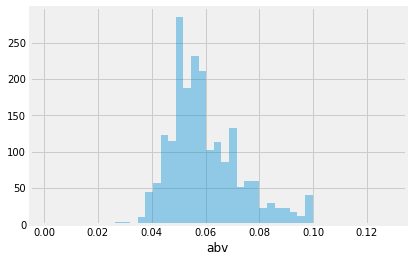

In [33]:
# histogram of abv
sns.distplot(df['abv'], kde = False);

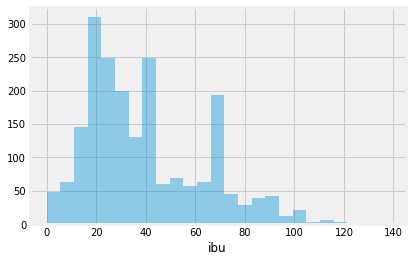

In [34]:
# histogram of ibu
sns.distplot(df['ibu'], kde = False);

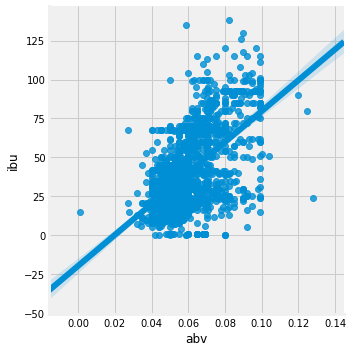

In [35]:
# I became curious to know if there tended to be any relationship between abv and ibu. It turns out there is one
# It's a bit messy, but there is a trend to observe.
sns.lmplot(x = 'abv', y = 'ibu', data = df);

### Additional Data Acquisition

Having not received by this stage a response from my API request to RateBeer, I determined that I would need to procure additional data to perform modeling, by any means. I considered scraping Rate Beer, however some manual searching turned up few results as compared to Beer Advocate, so I thought I would get more mileage out of Beer Advocate anyway.

I took the combined brewery name and beer name from the data that I had, and did some exploratory manual searches with them. What I found was that the search queries were pretty simple, and there were three types of responses:

1) The exact match was found, and would take me to the page of interest
2) Multiple matches were found, in which case I would assume the first result, and follow as though it were response 1.
3) No results were found.

I wrote a simple scraper which accounted for each of these possibilities. It takes the cleaned dataframe as input, loops through it, and passes as searches the brewery and beer name. The returned dataframe would indicate if no result has been found, or whether or not an exact match had been found, and the data I wanted from the site, which was the Score (score), the Average User Rating (avg) and the Number of Ratings (n_ratings), the last of which I thought could be interesting to explore as a proxy for popularity. The return also would have the index to merge the scraped data to the input data.

In [42]:
# First, I needed to reset the index so I wouldn't have trouble merging the data.
df.reset_index(drop = True, inplace = True)

In [70]:
def ba_scraper(df):
    # instantiate return data frame
    results = pd.DataFrame()
    
    # loop through the data frame
    for i in range(len(df)):
        # instantiate a new row to append to the return data frame
        result_dict = {'index': i,
                       'found': True,
                       'exact': True,
                       'score': None,
                       'avg': None, 
                       'n_ratings': None,
                       'url': None
                      }

        # form search query and submit
        srch = '+'.join(' '.join([df['brewery'][i], df['name'][i]]).split())
        url = 'https://www.beeradvocate.com/search/?q=' + srch + '&qt=beer'
        r = requests.post(url)
        
        # print statements to keep me sane
        print(i, r)
        
        # conditional for query not found 
        if re.search('No results', r.content.decode('utf-8')):
            print('not found\n')
            result_dict['found'] = False
            results = results.append(result_dict, ignore_index = True)
            continue
        
        # conditional for multiple results; take first result path
        if re.search('Found: \d', r.content.decode('utf-8')):
            print('took first result\n')
            result_dict['exact'] = False
            redirect = re.search('(\/beer\/profile\/\d{1,5}\/\d{1,7})',
                                 r.content.decode('utf-8'))
            url = 'https://www.beeradvocate.com' + redirect.group(1)
            r = requests.post(url)
            
        # scraping the score, n_ratings, and user average rating
        score = re.search('Score: (\d{1,3}) ', r.content.decode('utf-8'))
        n_ratings = re.search('Number of ratings for this beer\.\"\>(\d{1,3}|\d{1,3}\,\d{3})\<', r.content.decode('utf-8'))
        avg = re.search('across all ratings for this beer\.\"\>(\d\.\d)', r.content.decode('utf-8'))
        
        # conditionals in case these values were blank
        if score:
            result_dict['score'] = int(score.group(1))
        if avg:
            result_dict['avg'] = float(avg.group(1))
        if n_ratings:
            result_dict['n_ratings'] = int(n_ratings.group(1).replace(',',''))
            
        # also included the source url for QC
        result_dict['url'] = url
        
        
        results = results.append(result_dict, ignore_index = True)
        print(result_dict)
        
        # since this was my only data source, I really didn't want to get my IP blocked, overwhelm the host 
        # or otherwise stymie my data acquisition. thus I added this delay. When I finally got everything working
        # correctly, it would take a little over an hour to submit 2000+ requests
        time.sleep(1)
    
    return results

In [73]:
scrape_df = ba_scraper(df)

0 <Response [200]>
not found

1 <Response [200]>
{'index': 1, 'found': True, 'exact': True, 'score': 87, 'avg': 3.9, 'n_ratings': 112, 'url': "https://www.beeradvocate.com/search/?q=18th+Street+Brewery+Devil's+Cup&qt=beer"}
2 <Response [200]>
{'index': 2, 'found': True, 'exact': True, 'score': 90, 'avg': 4.1, 'n_ratings': 61, 'url': 'https://www.beeradvocate.com/search/?q=18th+Street+Brewery+Rise+of+the+Phoenix&qt=beer'}
3 <Response [200]>
{'index': 3, 'found': True, 'exact': True, 'score': 92, 'avg': 4.1, 'n_ratings': 183, 'url': 'https://www.beeradvocate.com/search/?q=18th+Street+Brewery+Sinister&qt=beer'}
4 <Response [200]>
{'index': 4, 'found': True, 'exact': True, 'score': 89, 'avg': 3.9, 'n_ratings': 201, 'url': 'https://www.beeradvocate.com/search/?q=18th+Street+Brewery+Sex+and+Candy&qt=beer'}
5 <Response [200]>
took first result

{'index': 5, 'found': True, 'exact': False, 'score': 90, 'avg': 4.1, 'n_ratings': 137, 'url': 'https://www.beeradvocate.com/beer/profile/31042/152141'

61 <Response [200]>
not found

62 <Response [200]>
not found

63 <Response [200]>
took first result

{'index': 63, 'found': True, 'exact': False, 'score': 84, 'avg': 3.7, 'n_ratings': 109, 'url': 'https://www.beeradvocate.com/beer/profile/26850/78732'}
64 <Response [200]>
{'index': 64, 'found': True, 'exact': True, 'score': 90, 'avg': 4.0, 'n_ratings': 748, 'url': 'https://www.beeradvocate.com/search/?q=Against+the+Grain+Brewery+Rico+Sauvin&qt=beer'}
65 <Response [200]>
took first result

{'index': 65, 'found': True, 'exact': False, 'score': 84, 'avg': 3.7, 'n_ratings': 49, 'url': 'https://www.beeradvocate.com/beer/profile/26850/171157'}
66 <Response [200]>
{'index': 66, 'found': True, 'exact': True, 'score': 85, 'avg': 3.7, 'n_ratings': 129, 'url': 'https://www.beeradvocate.com/search/?q=Against+the+Grain+Brewery+Kamen+Knuddeln&qt=beer'}
67 <Response [200]>
{'index': 67, 'found': True, 'exact': True, 'score': 86, 'avg': 3.8, 'n_ratings': 150, 'url': 'https://www.beeradvocate.com/searc

123 <Response [200]>
{'index': 123, 'found': True, 'exact': True, 'score': 86, 'avg': 3.9, 'n_ratings': 11, 'url': 'https://www.beeradvocate.com/search/?q=Astoria+Brewing+Company+Poop+Deck+Porter&qt=beer'}
124 <Response [200]>
{'index': 124, 'found': True, 'exact': True, 'score': None, 'avg': 3.0, 'n_ratings': 4, 'url': 'https://www.beeradvocate.com/search/?q=Astoria+Brewing+Company+Old+Red+Beard+Amber+Ale&qt=beer'}
125 <Response [200]>
{'index': 125, 'found': True, 'exact': True, 'score': 79, 'avg': 3.3, 'n_ratings': 235, 'url': 'https://www.beeradvocate.com/search/?q=Atwater+Brewery+Hop+A-Peel&qt=beer'}
126 <Response [200]>
took first result

{'index': 126, 'found': True, 'exact': False, 'score': 79, 'avg': 3.4, 'n_ratings': 1843, 'url': 'https://www.beeradvocate.com/beer/profile/15280/33336'}
127 <Response [200]>
{'index': 127, 'found': True, 'exact': True, 'score': 70, 'avg': 1.9, 'n_ratings': 16, 'url': 'https://www.beeradvocate.com/search/?q=Atwater+Brewery+Michelada&qt=beer'}
12

178 <Response [200]>
not found

179 <Response [200]>
not found

180 <Response [200]>
not found

181 <Response [200]>
not found

182 <Response [200]>
not found

183 <Response [200]>
not found

184 <Response [200]>
not found

185 <Response [200]>
not found

186 <Response [200]>
not found

187 <Response [200]>
not found

188 <Response [200]>
not found

189 <Response [200]>
not found

190 <Response [200]>
not found

191 <Response [200]>
not found

192 <Response [200]>
{'index': 192, 'found': True, 'exact': True, 'score': 84, 'avg': 3.7, 'n_ratings': 1822, 'url': "https://www.beeradvocate.com/search/?q=Bell's+Brewery+Smitten&qt=beer"}
193 <Response [200]>
{'index': 193, 'found': True, 'exact': True, 'score': 83, 'avg': 3.6, 'n_ratings': 2425, 'url': "https://www.beeradvocate.com/search/?q=Bell's+Brewery+Winter+White&qt=beer"}
194 <Response [200]>
took first result

{'index': 194, 'found': True, 'exact': False, 'score': 95, 'avg': 4.3, 'n_ratings': 15243, 'url': 'https://www.beeradvocate.com

264 <Response [200]>
not found

265 <Response [200]>
not found

266 <Response [200]>
not found

267 <Response [200]>
not found

268 <Response [200]>
not found

269 <Response [200]>
not found

270 <Response [200]>
{'index': 270, 'found': True, 'exact': True, 'score': 82, 'avg': 3.4, 'n_ratings': 112, 'url': 'https://www.beeradvocate.com/search/?q=Blue+Hills+Brewery+Quarter+Mile+Double+IPA&qt=beer'}
271 <Response [200]>
{'index': 271, 'found': True, 'exact': True, 'score': 85, 'avg': 3.8, 'n_ratings': 147, 'url': 'https://www.beeradvocate.com/search/?q=Blue+Mountain+Brewery+Steel+Wheels+ESB&qt=beer'}
272 <Response [200]>
{'index': 272, 'found': True, 'exact': True, 'score': 78, 'avg': 3.5, 'n_ratings': 144, 'url': 'https://www.beeradvocate.com/search/?q=Blue+Mountain+Brewery+Blue+Mountain+Classic+Lager&qt=beer'}
273 <Response [200]>
{'index': 273, 'found': True, 'exact': True, 'score': 82, 'avg': 3.6, 'n_ratings': 236, 'url': 'https://www.beeradvocate.com/search/?q=Blue+Mountain+Brewery+

{'index': 334, 'found': True, 'exact': False, 'score': None, 'avg': 3.7, 'n_ratings': 6, 'url': 'https://www.beeradvocate.com/beer/profile/33496/271478'}
335 <Response [200]>
{'index': 335, 'found': True, 'exact': True, 'score': 84, 'avg': 3.8, 'n_ratings': 43, 'url': 'https://www.beeradvocate.com/search/?q=Brewery+Terra+Firma+Manitou+Amber&qt=beer'}
336 <Response [200]>
{'index': 336, 'found': True, 'exact': True, 'score': None, 'avg': 3.5, 'n_ratings': 1, 'url': 'https://www.beeradvocate.com/search/?q=Brewery+Vivant+Belfort&qt=beer'}
337 <Response [200]>
{'index': 337, 'found': True, 'exact': True, 'score': None, 'avg': 3.8, 'n_ratings': 4, 'url': 'https://www.beeradvocate.com/search/?q=Brewery+Vivant+Star+Runner&qt=beer'}
338 <Response [200]>
took first result

{'index': 338, 'found': True, 'exact': False, 'score': 92, 'avg': 4.2, 'n_ratings': 22, 'url': 'https://www.beeradvocate.com/beer/profile/24678/192245'}
339 <Response [200]>
not found

340 <Response [200]>
{'index': 340, 'fou

381 <Response [200]>
not found

382 <Response [200]>
{'index': 382, 'found': True, 'exact': True, 'score': 83, 'avg': 3.4, 'n_ratings': 51, 'url': 'https://www.beeradvocate.com/search/?q=Brewery+Vivant+Kludde&qt=beer'}
383 <Response [200]>
took first result

{'index': 383, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 551, 'url': 'https://www.beeradvocate.com/beer/profile/24678/65534'}
384 <Response [200]>
took first result

{'index': 384, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 201, 'url': 'https://www.beeradvocate.com/beer/profile/24678/68948'}
385 <Response [200]>
took first result

{'index': 385, 'found': True, 'exact': False, 'score': 86, 'avg': 3.8, 'n_ratings': 472, 'url': 'https://www.beeradvocate.com/beer/profile/24678/65517'}
386 <Response [200]>
not found

387 <Response [200]>
not found

388 <Response [200]>
not found

389 <Response [200]>
not found

390 <Response [200]>
not found

391 <Response [200]>
not found

392 <Respo

{'index': 444, 'found': True, 'exact': False, 'score': 82, 'avg': 3.6, 'n_ratings': 182, 'url': 'https://www.beeradvocate.com/beer/profile/9602/17592'}
445 <Response [200]>
{'index': 445, 'found': True, 'exact': True, 'score': 79, 'avg': 3.4, 'n_ratings': 133, 'url': 'https://www.beeradvocate.com/search/?q=Cape+Cod+Beer+Beach+Blonde&qt=beer'}
446 <Response [200]>
not found

447 <Response [200]>
{'index': 447, 'found': True, 'exact': True, 'score': 80, 'avg': 3.5, 'n_ratings': 461, 'url': 'https://www.beeradvocate.com/search/?q=Capital+Brewery+Wisconsin+Amber&qt=beer'}
448 <Response [200]>
not found

449 <Response [200]>
{'index': 449, 'found': True, 'exact': True, 'score': 78, 'avg': 3.3, 'n_ratings': 210, 'url': 'https://www.beeradvocate.com/search/?q=Capital+Brewery+Mutiny+IPA&qt=beer'}
450 <Response [200]>
{'index': 450, 'found': True, 'exact': True, 'score': 78, 'avg': 3.3, 'n_ratings': 269, 'url': 'https://www.beeradvocate.com/search/?q=Capital+Brewery+Island+Wheat&qt=beer'}
451 <

519 <Response [200]>
not found

520 <Response [200]>
not found

521 <Response [200]>
not found

522 <Response [200]>
not found

523 <Response [200]>
not found

524 <Response [200]>
not found

525 <Response [200]>
not found

526 <Response [200]>
not found

527 <Response [200]>
not found

528 <Response [200]>
{'index': 528, 'found': True, 'exact': True, 'score': 71, 'avg': 3.2, 'n_ratings': 34, 'url': 'https://www.beeradvocate.com/search/?q=Cisco+Brewers+Shark+Tracker+Light+lager&qt=beer'}
529 <Response [200]>
{'index': 529, 'found': True, 'exact': True, 'score': 80, 'avg': 3.5, 'n_ratings': 663, 'url': 'https://www.beeradvocate.com/search/?q=Cisco+Brewers+Pumple+Drumkin&qt=beer'}
530 <Response [200]>
{'index': 530, 'found': True, 'exact': True, 'score': 81, 'avg': 3.5, 'n_ratings': 754, 'url': 'https://www.beeradvocate.com/search/?q=Cisco+Brewers+Grey+Lady&qt=beer'}
531 <Response [200]>
{'index': 531, 'found': True, 'exact': True, 'score': 83, 'avg': 3.6, 'n_ratings': 319, 'url': 'https

{'index': 599, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 88, 'url': 'https://www.beeradvocate.com/beer/profile/27403/114990'}
600 <Response [200]>
took first result

{'index': 600, 'found': True, 'exact': False, 'score': 86, 'avg': 3.8, 'n_ratings': 246, 'url': 'https://www.beeradvocate.com/beer/profile/27403/75574'}
601 <Response [200]>
{'index': 601, 'found': True, 'exact': True, 'score': 83, 'avg': 3.6, 'n_ratings': 95, 'url': 'https://www.beeradvocate.com/search/?q=Deep+Ellum+Brewing+Company+Farmhouse+Wit&qt=beer'}
602 <Response [200]>
not found

603 <Response [200]>
{'index': 603, 'found': True, 'exact': True, 'score': 80, 'avg': 3.5, 'n_ratings': 347, 'url': 'https://www.beeradvocate.com/search/?q=Deep+Ellum+Brewing+Company+Dallas+Blonde&qt=beer'}
604 <Response [200]>
took first result

{'index': 604, 'found': True, 'exact': False, 'score': 90, 'avg': 4.0, 'n_ratings': 908, 'url': 'https://www.beeradvocate.com/beer/profile/27403/77627'}
605 <Response [2

675 <Response [200]>
{'index': 675, 'found': True, 'exact': True, 'score': 83, 'avg': 3.6, 'n_ratings': 15, 'url': 'https://www.beeradvocate.com/search/?q=Fate+Brewing+Company+Norns+Roggenbier&qt=beer'}
676 <Response [200]>
{'index': 676, 'found': True, 'exact': True, 'score': 83, 'avg': 3.7, 'n_ratings': 38, 'url': 'https://www.beeradvocate.com/search/?q=Fate+Brewing+Company+Laimas+Kölsch+Style+Ale&qt=beer'}
677 <Response [200]>
{'index': 677, 'found': True, 'exact': True, 'score': 87, 'avg': 3.9, 'n_ratings': 71, 'url': 'https://www.beeradvocate.com/search/?q=Fate+Brewing+Company+Moirai+India+Pale+Ale&qt=beer'}
678 <Response [200]>
{'index': 678, 'found': True, 'exact': True, 'score': 80, 'avg': 3.3, 'n_ratings': 21, 'url': 'https://www.beeradvocate.com/search/?q=Fearless+Brewing+Company+Peaches+&+Cream&qt=beer'}
679 <Response [200]>
not found

680 <Response [200]>
{'index': 680, 'found': True, 'exact': True, 'score': 84, 'avg': 3.5, 'n_ratings': 58, 'url': 'https://www.beeradvocate.

737 <Response [200]>
{'index': 737, 'found': True, 'exact': True, 'score': 84, 'avg': 3.7, 'n_ratings': 263, 'url': 'https://www.beeradvocate.com/search/?q=Four+Corners+Brewing+Company+El+Chingon+IPA&qt=beer'}
738 <Response [200]>
{'index': 738, 'found': True, 'exact': True, 'score': 88, 'avg': 4.0, 'n_ratings': 95, 'url': 'https://www.beeradvocate.com/search/?q=Four+Corners+Brewing+Company+Block+Party+Robust+Porter&qt=beer'}
739 <Response [200]>
{'index': 739, 'found': True, 'exact': True, 'score': 81, 'avg': 3.5, 'n_ratings': 160, 'url': 'https://www.beeradvocate.com/search/?q=Four+Corners+Brewing+Company+Local+Buzz&qt=beer'}
740 <Response [200]>
{'index': 740, 'found': True, 'exact': True, 'score': 86, 'avg': 3.8, 'n_ratings': 11, 'url': "https://www.beeradvocate.com/search/?q=Four+Fathers+Brewing+Feel+Like+Maplin'+Love&qt=beer"}
741 <Response [200]>
{'index': 741, 'found': True, 'exact': True, 'score': None, 'avg': 3.9, 'n_ratings': 8, 'url': "https://www.beeradvocate.com/search/?q

785 <Response [200]>
took first result

{'index': 785, 'found': True, 'exact': False, 'score': 84, 'avg': 3.7, 'n_ratings': 256, 'url': 'https://www.beeradvocate.com/beer/profile/26932/77876'}
786 <Response [200]>
not found

787 <Response [200]>
took first result

{'index': 787, 'found': True, 'exact': False, 'score': 89, 'avg': 4.0, 'n_ratings': 107, 'url': 'https://www.beeradvocate.com/beer/profile/33837/112118'}
788 <Response [200]>
{'index': 788, 'found': True, 'exact': True, 'score': 90, 'avg': 4.0, 'n_ratings': 494, 'url': 'https://www.beeradvocate.com/search/?q=Good+Life+Brewing+Company+Descender+IPA&qt=beer'}
789 <Response [200]>
{'index': 789, 'found': True, 'exact': True, 'score': 85, 'avg': 3.8, 'n_ratings': 195, 'url': 'https://www.beeradvocate.com/search/?q=Good+Life+Brewing+Company+Sweet+As+Pacific+Ale&qt=beer'}
790 <Response [200]>
took first result

{'index': 790, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 231, 'url': 'https://www.beeradvocate.

849 <Response [200]>
not found

850 <Response [200]>
not found

851 <Response [200]>
not found

852 <Response [200]>
{'index': 852, 'found': True, 'exact': True, 'score': 77, 'avg': 3.3, 'n_ratings': 187, 'url': 'https://www.beeradvocate.com/search/?q=Grey+Sail+Brewing+of+Rhode+Island+Flagship+Ale&qt=beer'}
853 <Response [200]>
{'index': 853, 'found': True, 'exact': True, 'score': 82, 'avg': 3.6, 'n_ratings': 80, 'url': 'https://www.beeradvocate.com/search/?q=Griffin+Claw+Brewing+Company+Mr.+Blue+Sky&qt=beer'}
854 <Response [200]>
took first result

{'index': 854, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 75, 'url': 'https://www.beeradvocate.com/beer/profile/32166/106033'}
855 <Response [200]>
not found

856 <Response [200]>
not found

857 <Response [200]>
{'index': 857, 'found': True, 'exact': True, 'score': 84, 'avg': 3.7, 'n_ratings': 156, 'url': 'https://www.beeradvocate.com/search/?q=Griffin+Claw+Brewing+Company+El+Rojo&qt=beer'}
858 <Response [200]>
too

{'index': 917, 'found': True, 'exact': False, 'score': 99, 'avg': 4.4, 'n_ratings': 13702, 'url': 'https://www.beeradvocate.com/beer/profile/287/17112'}
918 <Response [200]>
took first result

{'index': 918, 'found': True, 'exact': False, 'score': 99, 'avg': 4.4, 'n_ratings': 13702, 'url': 'https://www.beeradvocate.com/beer/profile/287/17112'}
919 <Response [200]>
took first result

{'index': 919, 'found': True, 'exact': False, 'score': 99, 'avg': 4.4, 'n_ratings': 13702, 'url': 'https://www.beeradvocate.com/beer/profile/287/17112'}
920 <Response [200]>
took first result

{'index': 920, 'found': True, 'exact': False, 'score': 99, 'avg': 4.4, 'n_ratings': 13702, 'url': 'https://www.beeradvocate.com/beer/profile/287/17112'}
921 <Response [200]>
took first result

{'index': 921, 'found': True, 'exact': False, 'score': 99, 'avg': 4.4, 'n_ratings': 13702, 'url': 'https://www.beeradvocate.com/beer/profile/287/17112'}
922 <Response [200]>
not found

923 <Response [200]>
{'index': 923, 'found'

994 <Response [200]>
{'index': 994, 'found': True, 'exact': True, 'score': 79, 'avg': 3.4, 'n_ratings': 81, 'url': 'https://www.beeradvocate.com/search/?q=Keweenaw+Brewing+Company+Olde+Ore+Dock+Scottish+Ale&qt=beer'}
995 <Response [200]>
{'index': 995, 'found': True, 'exact': True, 'score': 80, 'avg': 3.5, 'n_ratings': 344, 'url': 'https://www.beeradvocate.com/search/?q=Keweenaw+Brewing+Company+Widow+Maker+Black+Ale&qt=beer'}
996 <Response [200]>
{'index': 996, 'found': True, 'exact': True, 'score': 80, 'avg': 3.4, 'n_ratings': 119, 'url': 'https://www.beeradvocate.com/search/?q=Keweenaw+Brewing+Company+Lift+Bridge+Brown+Ale&qt=beer'}
997 <Response [200]>
{'index': 997, 'found': True, 'exact': True, 'score': 76, 'avg': 3.3, 'n_ratings': 160, 'url': 'https://www.beeradvocate.com/search/?q=Keweenaw+Brewing+Company+Pick+Axe+Blonde+Ale&qt=beer'}
998 <Response [200]>
{'index': 998, 'found': True, 'exact': True, 'score': 79, 'avg': 3.4, 'n_ratings': 148, 'url': 'https://www.beeradvocate.com/

1049 <Response [200]>
{'index': 1049, 'found': True, 'exact': True, 'score': 84, 'avg': 3.7, 'n_ratings': 57, 'url': "https://www.beeradvocate.com/search/?q=Lucette+Brewing+Company+Hips+Don't+Lie&qt=beer"}
1050 <Response [200]>
not found

1051 <Response [200]>
{'index': 1051, 'found': True, 'exact': True, 'score': None, 'avg': 4.1, 'n_ratings': 1, 'url': "https://www.beeradvocate.com/search/?q=Lucette+Brewing+Company+The+Farmer's+Daughter&qt=beer"}
1052 <Response [200]>
not found

1053 <Response [200]>
not found

1054 <Response [200]>
{'index': 1054, 'found': True, 'exact': True, 'score': 85, 'avg': 3.7, 'n_ratings': 93, 'url': 'https://www.beeradvocate.com/search/?q=Lumberyard+Brewing+Company+Knotty+Pine&qt=beer'}
1055 <Response [200]>
took first result

{'index': 1055, 'found': True, 'exact': False, 'score': None, 'avg': 3.1, 'n_ratings': 9, 'url': 'https://www.beeradvocate.com/beer/profile/23675/94205'}
1056 <Response [200]>
took first result

{'index': 1056, 'found': True, 'exact':

{'index': 1140, 'found': True, 'exact': False, 'score': 81, 'avg': 3.5, 'n_ratings': 29, 'url': 'https://www.beeradvocate.com/beer/profile/3925/33782'}
1141 <Response [200]>
not found

1142 <Response [200]>
not found

1143 <Response [200]>
not found

1144 <Response [200]>
not found

1145 <Response [200]>
not found

1146 <Response [200]>
not found

1147 <Response [200]>
not found

1148 <Response [200]>
not found

1149 <Response [200]>
not found

1150 <Response [200]>
{'index': 1150, 'found': True, 'exact': True, 'score': 89, 'avg': 3.9, 'n_ratings': 33, 'url': 'https://www.beeradvocate.com/search/?q=Mikerphone+Brewing+Vinyl+Frontier&qt=beer'}
1151 <Response [200]>
took first result

{'index': 1151, 'found': True, 'exact': False, 'score': 89, 'avg': 4.1, 'n_ratings': 24, 'url': 'https://www.beeradvocate.com/beer/profile/39889/175018'}
1152 <Response [200]>
{'index': 1152, 'found': True, 'exact': True, 'score': 87, 'avg': 3.9, 'n_ratings': 24, 'url': 'https://www.beeradvocate.com/search/?

1196 <Response [200]>
{'index': 1196, 'found': True, 'exact': True, 'score': 81, 'avg': 3.5, 'n_ratings': 33, 'url': 'https://www.beeradvocate.com/search/?q=Mogollon+Brewing+Company+Wapiti+Amber+Ale&qt=beer'}
1197 <Response [200]>
took first result

{'index': 1197, 'found': True, 'exact': False, 'score': 85, 'avg': 3.8, 'n_ratings': 33, 'url': 'https://www.beeradvocate.com/beer/profile/26704/76281'}
1198 <Response [200]>
took first result

{'index': 1198, 'found': True, 'exact': False, 'score': 85, 'avg': 3.8, 'n_ratings': 33, 'url': 'https://www.beeradvocate.com/beer/profile/26704/76281'}
1199 <Response [200]>
took first result

{'index': 1199, 'found': True, 'exact': False, 'score': 85, 'avg': 3.8, 'n_ratings': 33, 'url': 'https://www.beeradvocate.com/beer/profile/26704/76281'}
1200 <Response [200]>
{'index': 1200, 'found': True, 'exact': True, 'score': 82, 'avg': 3.5, 'n_ratings': 72, 'url': 'https://www.beeradvocate.com/search/?q=Montauk+Brewing+Company+Montauk+Summer+Ale&qt=beer'}

1265 <Response [200]>
{'index': 1265, 'found': True, 'exact': True, 'score': 83, 'avg': 3.6, 'n_ratings': 172, 'url': 'https://www.beeradvocate.com/search/?q=Newburyport+Brewing+Company+Newburyport+Pale+Ale&qt=beer'}
1266 <Response [200]>
{'index': 1266, 'found': True, 'exact': True, 'score': 81, 'avg': 3.5, 'n_ratings': 56, 'url': 'https://www.beeradvocate.com/search/?q=Night+Shift+Brewing+Marblehead&qt=beer'}
1267 <Response [200]>
{'index': 1267, 'found': True, 'exact': True, 'score': 86, 'avg': 3.8, 'n_ratings': 492, 'url': 'https://www.beeradvocate.com/search/?q=NoDa+Brewing+Company+Jam+Session&qt=beer'}
1268 <Response [200]>
not found

1269 <Response [200]>
not found

1270 <Response [200]>
not found

1271 <Response [200]>
not found

1272 <Response [200]>
not found

1273 <Response [200]>
{'index': 1273, 'found': True, 'exact': True, 'score': 87, 'avg': 3.8, 'n_ratings': 21, 'url': 'https://www.beeradvocate.com/search/?q=NorthGate+Brewing+Get+Together&qt=beer'}
1274 <Response [200]>

1317 <Response [200]>
{'index': 1317, 'found': True, 'exact': True, 'score': 81, 'avg': 3.5, 'n_ratings': 19, 'url': 'https://www.beeradvocate.com/search/?q=Old+Forge+Brewing+Company+Endless+Sun+Ale&qt=beer'}
1318 <Response [200]>
{'index': 1318, 'found': True, 'exact': True, 'score': 81, 'avg': 3.5, 'n_ratings': 55, 'url': 'https://www.beeradvocate.com/search/?q=Old+Forge+Brewing+Company+Celestial+Blonde+Ale&qt=beer'}
1319 <Response [200]>
{'index': 1319, 'found': True, 'exact': True, 'score': 85, 'avg': 3.7, 'n_ratings': 198, 'url': 'https://www.beeradvocate.com/search/?q=Old+Forge+Brewing+Company+Overbite+IPA&qt=beer'}
1320 <Response [200]>
{'index': 1320, 'found': True, 'exact': True, 'score': 82, 'avg': 3.6, 'n_ratings': 128, 'url': 'https://www.beeradvocate.com/search/?q=Old+Forge+Brewing+Company+T-Rail+Pale+Ale&qt=beer'}
1321 <Response [200]>
{'index': 1321, 'found': True, 'exact': True, 'score': 77, 'avg': 3.2, 'n_ratings': 57, 'url': 'https://www.beeradvocate.com/search/?q=Old

1424 <Response [200]>
not found

1425 <Response [200]>
not found

1426 <Response [200]>
not found

1427 <Response [200]>
took first result

{'index': 1427, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 532, 'url': 'https://www.beeradvocate.com/beer/profile/9969/21192'}
1428 <Response [200]>
took first result

{'index': 1428, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 532, 'url': 'https://www.beeradvocate.com/beer/profile/9969/21192'}
1429 <Response [200]>
{'index': 1429, 'found': True, 'exact': True, 'score': 85, 'avg': 3.7, 'n_ratings': 233, 'url': 'https://www.beeradvocate.com/search/?q=Real+Ale+Brewing+Company+18th+Anniversary+Gose&qt=beer'}
1430 <Response [200]>
{'index': 1430, 'found': True, 'exact': True, 'score': 87, 'avg': 3.9, 'n_ratings': 152, 'url': 'https://www.beeradvocate.com/search/?q=Real+Ale+Brewing+Company+White&qt=beer'}
1431 <Response [200]>
{'index': 1431, 'found': True, 'exact': True, 'score': 91, 'avg': 4.1, 'n_rat

1504 <Response [200]>
not found

1505 <Response [200]>
not found

1506 <Response [200]>
not found

1507 <Response [200]>
{'index': 1507, 'found': True, 'exact': True, 'score': 84, 'avg': 3.6, 'n_ratings': 46, 'url': 'https://www.beeradvocate.com/search/?q=Round+Guys+Brewing+Sundown&qt=beer'}
1508 <Response [200]>
took first result

{'index': 1508, 'found': True, 'exact': False, 'score': 82, 'avg': 3.6, 'n_ratings': 32, 'url': 'https://www.beeradvocate.com/beer/profile/27844/148060'}
1509 <Response [200]>
took first result

{'index': 1509, 'found': True, 'exact': False, 'score': 85, 'avg': 3.7, 'n_ratings': 131, 'url': 'https://www.beeradvocate.com/beer/profile/27844/118148'}
1510 <Response [200]>
{'index': 1510, 'found': True, 'exact': True, 'score': 82, 'avg': 3.4, 'n_ratings': 19, 'url': 'https://www.beeradvocate.com/search/?q=Round+Guys+Brewing+Original+Slacker+Ale&qt=beer'}
1511 <Response [200]>
{'index': 1511, 'found': True, 'exact': True, 'score': 82, 'avg': 3.4, 'n_ratings': 29,

1597 <Response [200]>
not found

1598 <Response [200]>
not found

1599 <Response [200]>
not found

1600 <Response [200]>
not found

1601 <Response [200]>
not found

1602 <Response [200]>
not found

1603 <Response [200]>
not found

1604 <Response [200]>
not found

1605 <Response [200]>
{'index': 1605, 'found': True, 'exact': True, 'score': None, 'avg': 3.6, 'n_ratings': 9, 'url': 'https://www.beeradvocate.com/search/?q=Slanted+Rock+Brewing+Company+Iron+Butt+Red+Ale&qt=beer'}
1606 <Response [200]>
not found

1607 <Response [200]>
not found

1608 <Response [200]>
not found

1609 <Response [200]>
{'index': 1609, 'found': True, 'exact': True, 'score': 83, 'avg': 3.9, 'n_ratings': 21, 'url': 'https://www.beeradvocate.com/search/?q=Sleeping+Lady+Brewing+Company+Urban+Wilderness+Pale+Ale&qt=beer'}
1610 <Response [200]>
took first result

{'index': 1610, 'found': True, 'exact': False, 'score': 87, 'avg': 3.8, 'n_ratings': 38, 'url': 'https://www.beeradvocate.com/beer/profile/1853/132424'}
1611 

1690 <Response [200]>
{'index': 1690, 'found': True, 'exact': True, 'score': 73, 'avg': 3.0, 'n_ratings': 82, 'url': 'https://www.beeradvocate.com/search/?q=Stevens+Point+Brewery+Drop+Dead+Blonde&qt=beer'}
1691 <Response [200]>
not found

1692 <Response [200]>
not found

1693 <Response [200]>
{'index': 1693, 'found': True, 'exact': True, 'score': 76, 'avg': 3.2, 'n_ratings': 314, 'url': 'https://www.beeradvocate.com/search/?q=Stevens+Point+Brewery+Point+Amber+Classic&qt=beer'}
1694 <Response [200]>
not found

1695 <Response [200]>
{'index': 1695, 'found': True, 'exact': True, 'score': 80, 'avg': 3.5, 'n_ratings': 198, 'url': 'https://www.beeradvocate.com/search/?q=Stillwater+Artisanal+Ales+Brontide&qt=beer'}
1696 <Response [200]>
{'index': 1696, 'found': True, 'exact': True, 'score': 87, 'avg': 3.8, 'n_ratings': 535, 'url': 'https://www.beeradvocate.com/search/?q=Stillwater+Artisanal+Ales+Classique&qt=beer'}
1697 <Response [200]>
not found

1698 <Response [200]>
{'index': 1698, 'found'

1740 <Response [200]>
{'index': 1740, 'found': True, 'exact': True, 'score': 82, 'avg': 3.6, 'n_ratings': 129, 'url': 'https://www.beeradvocate.com/search/?q=Sunken+City+Brewing+Company+Red+Clay+IPA&qt=beer'}
1741 <Response [200]>
took first result

{'index': 1741, 'found': True, 'exact': False, 'score': 99, 'avg': 4.4, 'n_ratings': 2720, 'url': 'https://www.beeradvocate.com/beer/profile/13014/138735'}
1742 <Response [200]>
{'index': 1742, 'found': True, 'exact': True, 'score': 85, 'avg': 3.7, 'n_ratings': 342, 'url': 'https://www.beeradvocate.com/search/?q=Surly+Brewing+Company+Doomtree&qt=beer'}
1743 <Response [200]>
{'index': 1743, 'found': True, 'exact': True, 'score': 94, 'avg': 4.2, 'n_ratings': 1144, 'url': 'https://www.beeradvocate.com/search/?q=Surly+Brewing+Company+BLAKKR&qt=beer'}
1744 <Response [200]>
not found

1745 <Response [200]>
took first result

{'index': 1745, 'found': True, 'exact': False, 'score': 96, 'avg': 4.3, 'n_ratings': 1600, 'url': 'https://www.beeradvocate

1797 <Response [200]>
took first result

{'index': 1797, 'found': True, 'exact': False, 'score': 92, 'avg': 4.1, 'n_ratings': 395, 'url': 'https://www.beeradvocate.com/beer/profile/46317/112262'}
1798 <Response [200]>
took first result

{'index': 1798, 'found': True, 'exact': False, 'score': 99, 'avg': 4.4, 'n_ratings': 2242, 'url': 'https://www.beeradvocate.com/beer/profile/46317/114804'}
1799 <Response [200]>
{'index': 1799, 'found': True, 'exact': True, 'score': 93, 'avg': 4.1, 'n_ratings': 749, 'url': 'https://www.beeradvocate.com/search/?q=The+Alchemist+Beelzebub&qt=beer'}
1800 <Response [200]>
{'index': 1800, 'found': True, 'exact': True, 'score': 100, 'avg': 4.6, 'n_ratings': 4008, 'url': 'https://www.beeradvocate.com/search/?q=The+Alchemist+Focal+Banger&qt=beer'}
1801 <Response [200]>
took first result

{'index': 1801, 'found': True, 'exact': False, 'score': 100, 'avg': 4.7, 'n_ratings': 14585, 'url': 'https://www.beeradvocate.com/beer/profile/46317/16814'}
1802 <Response [200]

1857 <Response [200]>
{'index': 1857, 'found': True, 'exact': True, 'score': 79, 'avg': 3.4, 'n_ratings': 145, 'url': 'https://www.beeradvocate.com/search/?q=Tin+Roof+Brewing+Company+Voodoo+Bengal+Pale+Ale&qt=beer'}
1858 <Response [200]>
{'index': 1858, 'found': True, 'exact': True, 'score': 79, 'avg': 3.4, 'n_ratings': 149, 'url': 'https://www.beeradvocate.com/search/?q=Tin+Roof+Brewing+Company+Perfect+Tin+Amber&qt=beer'}
1859 <Response [200]>
took first result

{'index': 1859, 'found': True, 'exact': False, 'score': 80, 'avg': 3.5, 'n_ratings': 570, 'url': 'https://www.beeradvocate.com/beer/profile/156/120'}
1860 <Response [200]>
not found

1861 <Response [200]>
{'index': 1861, 'found': True, 'exact': True, 'score': 78, 'avg': 3.1, 'n_ratings': 12, 'url': 'https://www.beeradvocate.com/search/?q=Tonka+Beer+Company+Big+Island+Shandy&qt=beer'}
1862 <Response [200]>
not found

1863 <Response [200]>
not found

1864 <Response [200]>
{'index': 1864, 'found': True, 'exact': True, 'score': No

1920 <Response [200]>
{'index': 1920, 'found': True, 'exact': True, 'score': 82, 'avg': 3.6, 'n_ratings': 96, 'url': 'https://www.beeradvocate.com/search/?q=Uncommon+Brewers+Golden+State+Ale&qt=beer'}
1921 <Response [200]>
took first result

{'index': 1921, 'found': True, 'exact': False, 'score': 86, 'avg': 3.8, 'n_ratings': 182, 'url': 'https://www.beeradvocate.com/beer/profile/17962/47631'}
1922 <Response [200]>
{'index': 1922, 'found': True, 'exact': True, 'score': 83, 'avg': 3.6, 'n_ratings': 240, 'url': 'https://www.beeradvocate.com/search/?q=Uncommon+Brewers+Siamese+twin&qt=beer'}
1923 <Response [200]>
took first result

{'index': 1923, 'found': True, 'exact': False, 'score': 95, 'avg': 4.2, 'n_ratings': 606, 'url': 'https://www.beeradvocate.com/beer/profile/29377/103875'}
1924 <Response [200]>
took first result

{'index': 1924, 'found': True, 'exact': False, 'score': 89, 'avg': 3.9, 'n_ratings': 308, 'url': 'https://www.beeradvocate.com/beer/profile/29377/84258'}
1925 <Response 

1970 <Response [200]>
{'index': 1970, 'found': True, 'exact': True, 'score': 78, 'avg': 3.4, 'n_ratings': 249, 'url': 'https://www.beeradvocate.com/search/?q=Wachusett+Brewing+Company+Country+Pale+Ale&qt=beer'}
1971 <Response [200]>
{'index': 1971, 'found': True, 'exact': True, 'score': 80, 'avg': 3.4, 'n_ratings': 93, 'url': 'https://www.beeradvocate.com/search/?q=Wachusett+Brewing+Company+Pumpkan&qt=beer'}
1972 <Response [200]>
{'index': 1972, 'found': True, 'exact': True, 'score': 77, 'avg': 3.3, 'n_ratings': 479, 'url': 'https://www.beeradvocate.com/search/?q=Wachusett+Brewing+Company+Wachusett+Blueberry+Ale&qt=beer'}
1973 <Response [200]>
{'index': 1973, 'found': True, 'exact': True, 'score': 79, 'avg': 3.4, 'n_ratings': 43, 'url': 'https://www.beeradvocate.com/search/?q=Warbird+Brewing+Company+T-6+Red+Ale&qt=beer'}
1974 <Response [200]>
{'index': 1974, 'found': True, 'exact': True, 'score': 83, 'avg': 3.5, 'n_ratings': 41, 'url': 'https://www.beeradvocate.com/search/?q=Warped+Win

2040 <Response [200]>
{'index': 2040, 'found': True, 'exact': True, 'score': 80, 'avg': 3.5, 'n_ratings': 86, 'url': "https://www.beeradvocate.com/search/?q=Wynkoop+Brewing+Company+Patty's+Chile+Beer&qt=beer"}
2041 <Response [200]>
{'index': 2041, 'found': True, 'exact': True, 'score': 84, 'avg': 3.6, 'n_ratings': 85, 'url': 'https://www.beeradvocate.com/search/?q=Wynkoop+Brewing+Company+Colorojo+Imperial+Red+Ale&qt=beer'}
2042 <Response [200]>
{'index': 2042, 'found': True, 'exact': True, 'score': 83, 'avg': 3.4, 'n_ratings': 12, 'url': 'https://www.beeradvocate.com/search/?q=Wynkoop+Brewing+Company+Wynkoop+Pumpkin+Ale&qt=beer'}
2043 <Response [200]>
took first result

{'index': 2043, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 124, 'url': 'https://www.beeradvocate.com/beer/profile/986/91838'}
2044 <Response [200]>
took first result

{'index': 2044, 'found': True, 'exact': False, 'score': 83, 'avg': 3.6, 'n_ratings': 71, 'url': 'https://www.beeradvocate.com/be

In [89]:
# After getting it right, I didn't want to have to do that again, so I saved the results offline
scrape_df.to_csv('./data/ba_scrape.csv')

In [104]:
# almost 70% returned exact results. I felt that was not bad for my first web scraper. Unfortunately though, a little 
# less than %50 were not found, and would need to be excluded for lacking target data.
# some cursory QC into the inexact matches showed > 80% success rate, which was also pleasing.
scrape_df[(scrape_df['found'] != 0)]['exact'].value_counts()

1.0    735
0.0    344
Name: exact, dtype: int64

In [111]:
scrape_df = scrape_df[(scrape_df['found'] != 0)]

In [114]:
df_fnl = pd.merge(df, scrape_df, left_index = True, right_index = True)
df_fnl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079 entries, 1 to 2046
Data columns (total 15 columns):
abv          1079 non-null float64
ibu          1079 non-null float64
name         1079 non-null object
style        1079 non-null object
ounces       1079 non-null float64
brewery      1079 non-null object
city         1079 non-null object
state        1079 non-null object
avg          1066 non-null object
exact        1079 non-null float64
found        1079 non-null float64
index        1079 non-null float64
n_ratings    1079 non-null object
score        1006 non-null object
url          1079 non-null object
dtypes: float64(6), object(9)
memory usage: 134.9+ KB


In [ ]:
# some scraped data needed to be recast as float / int
df_fnl['avg'] = df_fnl['avg'].astype('float')
df_fnl['n_ratings'] = df_fnl['n_ratings'].astype('int')
df_fnl['score'] = df_fnl['score'].astype('int')

# still more observations to eliminate for lack of target data
df_fnl = df_fnl[~df_fnl['score'].isna()]
df_fnl = df_fnl[~df_fnl['avg'].isna()]

In [135]:
# again, wanted to save my progress to this point
df_fnl.to_csv('./data/df_final.csv')

In [2]:
df_fnl = pd.read_csv('./data/df_final.csv')

### Cleaning, Part II

I was finally ready to drop some columns which I did not think would be useful. 'name' and 'brewery' had served their purpose for acquiring additional data. 'city' and 'state' were likely irrelevant relevant, 'found', 'index', and 'url' were no longer need.

With an otherwise clean dataset, it was finally time to simplify 'style' into potentially useful variables.

In [5]:
#df_fnl.drop(['name','brewery','city','state','found','index','url'], axis = 1, inplace = True)
df_fnl.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
# style contained two types of keywords I thought would be interesting, one was regional, as seen here.
locs = ['Engl',
        'Belg',
        'America',
        'Scot',
        'Munic',
        'Berlin']

for l in locs:
    print(l, df_fnl[df_fnl['style'].str.contains(l)].shape[0])

Engl 32
Belg 34
America 596
Scot 11
Munic 11
Berlin 8


In [7]:
# The other was the type of beer.
styles = ['Ale',
          'APA',
          'IPA',
          'Lager',
          'Pils',
          'Cider',
          'Stout',
          'wine',
          'beer',
          'bier',
          'Kölsch',
          'Porter',
          'Märzen',
          'Gose',
          'tripel',
          'bock',
          'Bière',
          'Bock',
          'Hefeweizen']

for s in styles:
    print(s, df_fnl[df_fnl['style'].str.contains(s,case = False)].shape[0])

Ale 416
APA 97
IPA 235
Lager 56
Pils 36
Cider 3
Stout 55
wine 5
beer 38
bier 46
Kölsch 17
Porter 36
Märzen 13
Gose 7
tripel 5
bock 6
Bière 2
Bock 6
Hefeweizen 14


In [8]:
# I binarized style on the basis of the presence of those keywords if they numbered greater than 30
df_fnl['America'] = np.where(df_fnl['style'].str.contains('America'), 1, 0)
df_fnl['English'] = np.where(df_fnl['style'].str.contains('Engl'), 1, 0)
df_fnl['Belgian'] = np.where(df_fnl['style'].str.contains('Belg'), 1, 0)

df_fnl['ale'] = np.where(df_fnl['style'].str.contains('ala|apa|ipa', case = False), 1, 0)
df_fnl['lager'] = np.where(df_fnl['style'].str.contains('lager', case = False), 1, 0)
df_fnl['pils'] = np.where(df_fnl['style'].str.contains('pils', case = False), 1, 0)
df_fnl['stout'] = np.where(df_fnl['style'].str.contains('stout', case = False), 1, 0)
df_fnl['beer'] = np.where(df_fnl['style'].str.contains('beer|bier|Bière', case = False), 1, 0)
df_fnl['porter'] = np.where(df_fnl['style'].str.contains('porter', case = False), 1, 0)

df_fnl.drop('style',axis = 1, inplace = True)

In [9]:
df_fnl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 16 columns):
abv          1001 non-null float64
ibu          1001 non-null float64
ounces       1001 non-null float64
avg          1001 non-null float64
exact        1001 non-null float64
n_ratings    1001 non-null int64
score        1001 non-null int64
America      1001 non-null int64
English      1001 non-null int64
Belgian      1001 non-null int64
ale          1001 non-null int64
lager        1001 non-null int64
pils         1001 non-null int64
stout        1001 non-null int64
beer         1001 non-null int64
porter       1001 non-null int64
dtypes: float64(5), int64(11)
memory usage: 125.2 KB


### EDA, Part 2; Modeling Preparation

In [10]:
# looking for highly correlated variables, I noticed that avg and score were highly correlated. 
# BA's score methodology is simply the percentage of ratings which were above 3.75 out of 5.
# With such a tight relationship, it was clear one would go, which I decided would be score due to there methodology
# excluding data from the other target, avg
df_corr = pd.DataFrame(df_fnl.corr().unstack().sort_values(ascending = False))
df_corr.columns = ['corr']
df_corr[df_corr['corr'] < 1]

corr
avg       score      0.956215
score     avg        0.956215
ale       ibu        0.665458
ibu       ale        0.665458
          abv        0.556142
abv       ibu        0.556142
ale       America    0.528833
America   ale        0.528833
          ibu        0.481042
ibu       America    0.481042
abv       score      0.446705
score     abv        0.446705
ibu       score      0.422295
score     ibu        0.422295
abv       avg        0.409138
avg       abv        0.409138
n_ratings score      0.365664
score     n_ratings  0.365664
ibu       avg        0.356152
avg       ibu        0.356152
n_ratings avg        0.325368
avg       n_ratings  0.325368
score     ale        0.243037
ale       score      0.243037
          abv        0.210491
abv       ale        0.210491
ounces    abv        0.196002
abv       ounces     0.196002
ale       avg        0.193785
avg       ale        0.193785
...                       ...
exact     ibu       -0.143233
ibu       exact     -0.143233
ale       stout     -0.169860
stout     ale       -0.169860
ale       lager     -0.171488
lager     ale       -0.171488
abv       lager     -0.194347
lager     abv       -0.194347
          avg       -0.208698
avg       lager     -0.208698
ibu       lager     -0.209185
lager     ibu       -0.209185
ale       beer      -0.215971
beer      ale       -0.215971
America   English   -0.220449
English   America   -0.220449
exact     n_ratings -0.224352
n_ratings exact     -0.224352
Belgian   America   -0.227469
America   Belgian   -0.227469
score     lager     -0.244016
lager     score     -0.244016
ibu       beer      -0.247779
beer      ibu       -0.247779
avg       exact     -0.261518
exact     avg       -0.261518
score     exact     -0.277697
exact     score     -0.277697
beer      America   -0.371907
America   beer      -0.371907

[240 rows x 1 columns]

In [11]:
df_fnl.drop('score',axis = 1, inplace = True)

### Modeling

I decided to leverage Pipelines and GridSearch so that I could efficiently test Ridge and Lasso linear models, as well as Random Forest Regressors.

The X1 model is my attempt to model the 'avg' rating, and the X2 model is the attempt to predict the number of ratings.

In [12]:
# identifying the columns of interst
X1_cols = df_fnl.columns[df_fnl.columns != 'avg']
X2_cols = df_fnl.columns[df_fnl.columns != 'n_ratings']

X1 = df_fnl[X1_cols]
y1 = df_fnl['avg']
X2 = df_fnl[X2_cols]
y2 = df_fnl['n_ratings']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,
                                                        y1,
                                                        test_size = 0.2,
                                                        random_state=1)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,
                                                        y2,
                                                        test_size = 0.2,
                                                        random_state=1)

In [13]:
# instantiating the models
ss = StandardScaler()
lass = Lasso()
rr = Ridge()
rf = RandomForestRegressor()

In [14]:
# creating three pipes and param grids to feed into GridSearchCV
pipe1 = Pipeline([('ss', ss), ('lasso', lass)])
pipe2 = Pipeline([('ss', ss), ('ridge', rr)])
pipe3 = Pipeline([('ss', ss), ('rf', rf)])

param_grid1 = {'lasso__alpha': np.logspace(-3, 1, 200)}
param_grid2 = {'ridge__alpha': np.logspace(-6, 6, 200)}
param_grid3 = {'rf__max_features': [1,2,0.5,'sqrt','log2'],
               'rf__min_samples_leaf': [1,2,3,5,10],
               'rf__n_estimators': [1,5,10,25,100,1000]}

grid1 = GridSearchCV(estimator=pipe1, param_grid=param_grid1, cv=10)
grid2 = GridSearchCV(estimator=pipe2, param_grid=param_grid2, cv=10)
grid3 = GridSearchCV(estimator=pipe3, param_grid=param_grid3, cv=10)

In [15]:
grid1.fit(X1_train, y1_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': array([1.00000e-03, 1.04737e-03, ..., 9.54772e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
grid1.best_params_

{'lasso__alpha': 0.006080224261649427}

In [18]:
lass.set_params(alpha = 0.006080224261649427)
lass.fit(X1_train, y1_train)

Lasso(alpha=0.006080224261649427, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
lass.score(X1_test, y1_test)

0.20495016131003643

In [20]:
grid2.fit(X1_train, y1_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': array([1.00000e-06, 1.14895e-06, ..., 8.70359e+05, 1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
grid2.best_params_

{'ridge__alpha': 69.05513520162316}

In [22]:
rr.set_params(alpha = 69.05513520162316)
rr.fit(X1_train, y1_train)
rr.score(X1_test, y1_test)

0.21867676667039868

In [23]:
grid3.fit(X1_train, y1_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=No...='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf__max_features': [1, 2, 0.5, 'sqrt', 'log2'], 'rf__min_samples_leaf': [1, 2, 3, 5, 10], 'rf__n_estimators': [1, 5, 10, 25, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
grid3.best_params_

{'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 25}

In [27]:
grid3_results = pd.DataFrame(grid3.cv_results_)

In [30]:
grid3_results.columns.tolist()

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_rf__max_features',
 'param_rf__min_samples_leaf',
 'param_rf__n_estimators',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'split3_train_score',
 'split4_train_score',
 'split5_train_score',
 'split6_train_score',
 'split7_train_score',
 'split8_train_score',
 'split9_train_score',
 'mean_train_score',
 'std_train_score']

In [31]:
grid3_results['diff'] = grid3_results['mean_train_score'] - grid3_results['mean_test_score'] 

In [40]:
grid3_results[grid3_results['diff'] == grid3_results['diff'].min()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_features,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score,diff
26,0.006473,0.000423,0.001212,0.000105,1,10,10,"{'rf__max_features': 1, 'rf__min_samples_leaf'...",0.168704,0.339788,...,0.263033,0.281465,0.285756,0.308802,0.292921,0.26833,0.306471,0.285727,0.018993,0.055243


In [43]:
grid3_results.loc[26,'params']

{'rf__max_features': 1, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 10}

In [44]:
rf.set_params(max_features = 1,
              min_samples_leaf = 10,
              n_estimators = 10)
rf.fit(X1_train, y1_train)
rf.score(X1_test, y1_test)

0.19200570252339577

In [45]:
sorted(list(zip(rf.feature_importances_, X1_cols)), reverse = True)

[(0.29100002482497134, 'ibu'),
 (0.20474826653679826, 'n_ratings'),
 (0.14357156136678043, 'abv'),
 (0.10691009636872084, 'exact'),
 (0.08483638517194522, 'ounces'),
 (0.05123169634007117, 'ale'),
 (0.034947303337253786, 'America'),
 (0.030873494973560022, 'stout'),
 (0.01660048220855418, 'English'),
 (0.009930818574135119, 'porter'),
 (0.009475304502920164, 'beer'),
 (0.009405981132213057, 'pils'),
 (0.005526911245745154, 'Belgian'),
 (0.0009416734163313148, 'lager')]

In [47]:
grid3_results[grid3_results['rank_test_score'] == grid3_results['rank_test_score'].min()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_features,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score,diff
111,0.015826,0.000408,0.001699,0.000034,sqrt,5,25,"{'rf__max_features': 'sqrt', 'rf__min_samples_...",0.222504,0.483736,...,0.479677,0.490827,0.481962,0.483651,0.482664,0.477399,0.485292,0.480528,0.006259,0.158699


In [49]:
grid3_results.loc[111,'params']

{'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 25}

In [51]:
rf.set_params(max_features = 'sqrt',
              min_samples_leaf = 5,
              n_estimators = 25)
rf.fit(X1_train, y1_train)
rf.score(X1_test, y1_test)

0.25867405879544414

In [52]:
sorted(list(zip(rf.feature_importances_, X1_cols)), reverse = True)

[(0.3661303875879628, 'abv'),
 (0.21406462761726772, 'n_ratings'),
 (0.15801971942736467, 'ibu'),
 (0.09164075521049009, 'exact'),
 (0.050834047031805364, 'ounces'),
 (0.04073115150077594, 'lager'),
 (0.026841071755435215, 'ale'),
 (0.020638128105025758, 'America'),
 (0.009801768504110138, 'beer'),
 (0.007928019363643724, 'porter'),
 (0.006086854129327996, 'pils'),
 (0.00437067997209747, 'stout'),
 (0.0014767210615283003, 'English'),
 (0.0014360687331648487, 'Belgian')]

In [280]:
grid3.score(X1, y1)

0.5752996565441164

In [282]:
ss = StandardScaler()
rf = RandomForestRegressor()

In [286]:
rf.set_params(max_features = 'log2',
              min_samples_leaf = 3,
              n_estimators = 100)
rf.fit(X1, y1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [287]:
rf.score(X1, y1)

0.5761148212454228

In [289]:
sorted(list(zip(rf.feature_importances_, X1_cols)), reverse = True)

[(0.2762542095844174, 'abv'),
 (0.26933277238877706, 'n_ratings'),
 (0.22691240825067985, 'ibu'),
 (0.05787456931669326, 'exact'),
 (0.052375439014760466, 'ounces'),
 (0.03540263118363812, 'lager'),
 (0.02318193232561649, 'America'),
 (0.019318861546424707, 'ale'),
 (0.008988517119712023, 'beer'),
 (0.008239693145102388, 'stout'),
 (0.008122188901620345, 'porter'),
 (0.005134338968200302, 'pils'),
 (0.004599825246796497, 'Belgian'),
 (0.004262613007561116, 'English')]

In [292]:
refined_cols = ['abv', 'n_ratings', 'ibu', 'exact', 'ounces', 'lager', 'America', 'ale']

In [294]:
X3 = df_fnl[refined_cols]

In [295]:
grid3.fit(X3, y1)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=No...='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf__max_features': [1, 2, 0.5, 'sqrt', 'log2'], 'rf__min_samples_leaf': [1, 2, 3, 5, 10], 'rf__n_estimators': [1, 5, 10, 25, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [290]:
# attempting to predict n_ratings

In [268]:
grid1.fit(X2, y2)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': array([1.00000e-03, 1.04737e-03, ..., 9.54772e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [269]:
grid1.best_params_

{'lasso__alpha': 10.0}

In [271]:
grid1.score(X2,y2)

0.15463533822184627

In [272]:
grid2.fit(X2, y2)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': array([1.00000e-06, 1.14895e-06, ..., 8.70359e+05, 1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [273]:
grid2.best_params_

{'ridge__alpha': 3370.0643292719246}

In [274]:
grid2.score(X2,y2)

0.06976799542397694

In [275]:
grid3.fit(X2, y2)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=No...='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf__max_features': [1, 2, 0.5, 'sqrt', 'log2'], 'rf__min_samples_leaf': [1, 2, 3, 5, 10], 'rf__n_estimators': [1, 5, 10, 25, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [276]:
grid3.best_params_

{'rf__max_features': 2, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 10}

In [277]:
grid3.score(X2, y2)

0.3038910190381121